In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Image Transformation
Lets Transfrom our image into Tensor and apply std mean and div (calculated above) to it and club it with transforms.compose. 
Here transforms.Compose function will apply tranforms and call input one by one.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

### Creating Dataset
Now Lets create our TEST and TRAIN dataset using MNIST using above transforms test_transforms and train_transforms respectively

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


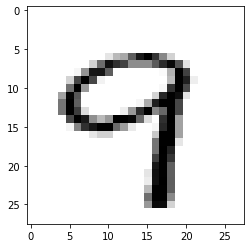

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### View our Data
Its important to see our data before we start to train it. by seeing the data we get to know what all tranformation we need to add to network

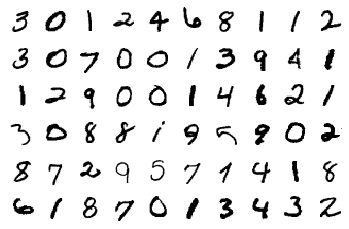

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Lets Build our Model


In [7]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

### Training and Testing
All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Training Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Now we train and testing our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06923743337392807 Batch_id=468 Training Accuracy=88.42: 100%|█████████████████| 469/469 [00:10<00:00, 46.38it/s]



Test set: Average loss: 0.0660, Test Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.09975648671388626 Batch_id=468 Training Accuracy=97.78: 100%|█████████████████| 469/469 [00:12<00:00, 38.60it/s]



Test set: Average loss: 0.0526, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.08519226312637329 Batch_id=468 Training Accuracy=98.31: 100%|█████████████████| 469/469 [00:15<00:00, 29.52it/s]



Test set: Average loss: 0.0364, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.08612067252397537 Batch_id=468 Training Accuracy=98.50: 100%|█████████████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0285, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.02154690958559513 Batch_id=468 Training Accuracy=98.69: 100%|█████████████████| 469/469 [00:34<00:00, 13.68it/s]



Test set: Average loss: 0.0301, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.02676176279783249 Batch_id=468 Training Accuracy=98.86: 100%|█████████████████| 469/469 [00:29<00:00, 15.63it/s]



Test set: Average loss: 0.0273, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.07805157452821732 Batch_id=468 Training Accuracy=98.92: 100%|█████████████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.0261, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.03504082188010216 Batch_id=468 Training Accuracy=98.89: 100%|█████████████████| 469/469 [00:26<00:00, 17.67it/s]



Test set: Average loss: 0.0253, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.03516658395528793 Batch_id=468 Training Accuracy=99.00: 100%|█████████████████| 469/469 [00:26<00:00, 17.65it/s]



Test set: Average loss: 0.0245, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.013520494103431702 Batch_id=468 Training Accuracy=99.09: 100%|████████████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0229, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.008277833461761475 Batch_id=468 Training Accuracy=99.06: 100%|████████████████| 469/469 [00:24<00:00, 18.89it/s]



Test set: Average loss: 0.0212, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.00988239049911499 Batch_id=468 Training Accuracy=99.17: 100%|█████████████████| 469/469 [00:28<00:00, 16.20it/s]



Test set: Average loss: 0.0245, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.057010699063539505 Batch_id=468 Training Accuracy=99.17: 100%|████████████████| 469/469 [00:25<00:00, 18.19it/s]



Test set: Average loss: 0.0249, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.028993165120482445 Batch_id=468 Training Accuracy=99.09: 100%|████████████████| 469/469 [00:26<00:00, 17.91it/s]



Test set: Average loss: 0.0198, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.0025819987058639526 Batch_id=468 Training Accuracy=99.21: 100%|███████████████| 469/469 [00:56<00:00,  8.25it/s]



Test set: Average loss: 0.0220, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.07761334627866745 Batch_id=468 Training Accuracy=99.20: 100%|█████████████████| 469/469 [01:00<00:00,  7.77it/s]



Test set: Average loss: 0.0210, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.0054454258643090725 Batch_id=468 Training Accuracy=99.24: 100%|███████████████| 469/469 [00:54<00:00,  8.64it/s]



Test set: Average loss: 0.0209, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.02090453915297985 Batch_id=468 Training Accuracy=99.27: 100%|█████████████████| 469/469 [00:34<00:00, 13.64it/s]



Test set: Average loss: 0.0196, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.05242409184575081 Batch_id=468 Training Accuracy=99.23: 100%|█████████████████| 469/469 [00:28<00:00, 16.30it/s]



Test set: Average loss: 0.0194, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.053295377641916275 Batch_id=468 Training Accuracy=99.26: 100%|████████████████| 469/469 [00:27<00:00, 17.05it/s]



Test set: Average loss: 0.0215, Test Accuracy: 9926/10000 (99.26%)



# Target:

    1. Add BatchNormalization (expect last layer) to increase efficiency of model 
    2. Add GAP layer to use less number of parameters in the last layer

# Results:

    Parameters: 6,070
    Best Training Accuracy:99.23
    Best Test Accuracy: 98.93
    
# Analysis:
    
   I have achieved 99.4 accuracy